In [156]:
!nvidia-smi

Sun Aug 21 15:58:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    31W /  70W |    610MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [157]:
import pandas as pd
import numpy as np
import torch
import os
from torch import nn
from matplotlib.pyplot import *
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import random

random.seed(1)
torch.manual_seed(1)
np.random.seed(1)
rng = np.random.default_rng(1)

In [158]:
!gdown --id '1gpneRAs5VoQECctq0WbA-9PRE7gD28sw' --output train.csv
!gdown --id '1qTeqdWcr1BHQeztTbcFyWe--aJjeDfQg' --output test.csv

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1gpneRAs5VoQECctq0WbA-9PRE7gD28sw
To: /content/train.csv
100% 61.2k/61.2k [00:00<00:00, 75.3MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1qTeqdWcr1BHQeztTbcFyWe--aJjeDfQg
To: /content/test.csv
100% 28.6k/28.6k [00:00<00:00, 41.4MB/s]


In [159]:
def describe_unique_dataset(df : pd.DataFrame, show_values = False):
    nunique = {}
    unique = {}
    nan = {}
    
    for col in df.columns:
        nunique[col] = df[col].nunique()
        unique[col] = df[col].unique()
        nan[col] = df[col].isna().sum()        

    print(f'Shape of Dataset : {df.shape}')
    print('----------------------------')
    
    print('\nNumber of Unique Values')
    print('-----------------------')
    [print(f'{item} : {nunique[item]}') for item in nunique.keys()]
        
    print('\nNumber of NaN Values')
    print('-----------------------')
    [print(f'{item} : {nan[item]}') for item in nan.keys()]
    
    if show_values == True:
        print('\nUnique Values in Data')
        print('-----------------------')
        [print(f'{item} : {unique[item]}') for item in unique.keys()]
        
def load_data(train_path, test_path):
  train_data = pd.read_csv(train_path)
  test_data = pd.read_csv(test_path)  
  return train_data, test_data

train_data, test_data = load_data('train.csv','test.csv')
print( f'train {train_data.shape}' )
print( f'test {test_data.shape}' )
#print(train_data.columns)
#print(test_data.columns)
train_data.head()        

train (891, 12)
test (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [160]:
train_data = train_data.drop(["Name", 'Ticket', 'Cabin','Parch'], axis=1)
test_data = test_data.drop(["Name", 'Ticket', 'Cabin','Parch'], axis=1)
#文字特徵數值化
train_data = pd.concat([train_data,   
              pd.get_dummies(train_data["Sex"]),
              pd.get_dummies(train_data['Embarked'], prefix="Embarked"), # prefix：指定前缀
              pd.get_dummies(train_data["Pclass"], prefix="Class")], axis=1)
test_data = pd.concat([test_data,
              pd.get_dummies(test_data["Sex"]),
              pd.get_dummies(test_data['Embarked'], prefix="Embarked"), # prefix：指定前缀
              pd.get_dummies(test_data["Pclass"], prefix="Class")], axis=1)
#捨棄原本特徵
train_data = train_data.drop(["Sex",'Embarked','Pclass'],axis=1)
test_data = test_data.drop(["Sex",'Embarked','Pclass'],axis=1)
#補值
train_data["Age"] = train_data["Age"].fillna(train_data["Age"].mean())
test_data["Age"] = test_data["Age"].fillna(test_data["Age"].mean())
test_data["Fare"] = test_data["Fare"].fillna(test_data["Fare"].mean())
print(train_data.columns) # 查看当前的列属性
describe_unique_dataset(train_data)

Index(['PassengerId', 'Survived', 'Age', 'SibSp', 'Fare', 'female', 'male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Class_1', 'Class_2',
       'Class_3'],
      dtype='object')
Shape of Dataset : (891, 13)
----------------------------

Number of Unique Values
-----------------------
PassengerId : 891
Survived : 2
Age : 89
SibSp : 7
Fare : 248
female : 2
male : 2
Embarked_C : 2
Embarked_Q : 2
Embarked_S : 2
Class_1 : 2
Class_2 : 2
Class_3 : 2

Number of NaN Values
-----------------------
PassengerId : 0
Survived : 0
Age : 0
SibSp : 0
Fare : 0
female : 0
male : 0
Embarked_C : 0
Embarked_Q : 0
Embarked_S : 0
Class_1 : 0
Class_2 : 0
Class_3 : 0


In [161]:
#分割訓練集測試集，此處測試集為0
labels = train_data["Survived"].to_numpy()
train_data = train_data.drop(["Survived"],axis=1)
data = train_data.to_numpy()
feature_names = list(train_data.columns)

np.random.seed(10) 
train_indices = np.random.choice(len(labels),int(1*len(labels)),replace=False)
test_indices = list(set(range(len(labels)))-set(train_indices))

 
train_features = data[train_indices]
train_labels = labels[train_indices]
test_features = data[test_indices]
test_labels = labels[test_indices]



In [162]:
class Mish(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,x):
        x = x * (torch.tanh(F.softplus(x)))
        return x
 
torch.manual_seed(0)  
class ThreelinearModel(nn.Module):
    def __init__(self):
        super(ThreelinearModel, self).__init__()
        self.linear1 = nn.Linear(12,12)
        self.mish1 = Mish()
        self.linear2 = nn.Linear(12,8)
        self.mish2 = Mish()
        self.linear3 = nn.Linear(8,2)
        self.softmax = nn.Softmax(dim=1)
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self,x):
        x = self.linear1(x)
        x = self.mish1(x)
        x = self.linear2(x)
        x = self.mish2(x)
        x = self.linear3(x)
        return self.softmax(x)
    
    def getloss(self,x,y):
        y_pre = self.forward(x)
        loss = self.criterion(y_pre,y)
        return loss

Train on device: cuda
epoch1/1000 => Loss:0.69
epoch21/1000 => Loss:0.61
epoch41/1000 => Loss:0.60
epoch61/1000 => Loss:0.59
epoch81/1000 => Loss:0.56
epoch101/1000 => Loss:0.54
epoch121/1000 => Loss:0.52
epoch141/1000 => Loss:0.51
epoch161/1000 => Loss:0.50
epoch181/1000 => Loss:0.49
epoch201/1000 => Loss:0.49
epoch221/1000 => Loss:0.48
epoch241/1000 => Loss:0.48
epoch261/1000 => Loss:0.48
epoch281/1000 => Loss:0.48
epoch301/1000 => Loss:0.48
epoch321/1000 => Loss:0.47
epoch341/1000 => Loss:0.47
epoch361/1000 => Loss:0.47
epoch381/1000 => Loss:0.47
epoch401/1000 => Loss:0.47
epoch421/1000 => Loss:0.47
epoch441/1000 => Loss:0.47
epoch461/1000 => Loss:0.47
epoch481/1000 => Loss:0.47
epoch501/1000 => Loss:0.47
epoch521/1000 => Loss:0.47
epoch541/1000 => Loss:0.47
epoch561/1000 => Loss:0.46
epoch581/1000 => Loss:0.46
epoch601/1000 => Loss:0.46
epoch621/1000 => Loss:0.46
epoch641/1000 => Loss:0.46
epoch661/1000 => Loss:0.46
epoch681/1000 => Loss:0.46
epoch701/1000 => Loss:0.46
epoch721/100

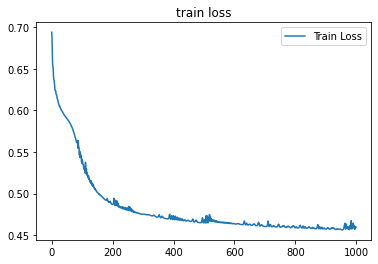

In [163]:
if __name__ == '__main__':
    
    net = ThreelinearModel()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Train on device: {device}')
    #net.to(device)  
    num_epochs = 1000 
    optimizer = torch.optim.Adam(net.parameters(), lr=0.005)  
 
    
    input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
    label_tensor = torch.from_numpy(train_labels)
    losses = []  
    for epoch in range(num_epochs):
        loss = net.getloss(input_tensor, label_tensor)
        losses.append(loss.item())
        optimizer.zero_grad()  
        loss.backward() 
        optimizer.step() 
        if epoch % 20 == 0:
            print("epoch{}/{} => Loss:{:.2f}".format(epoch+1, num_epochs,loss.item()))
    os.makedirs("models", exist_ok=True)  # 创建文件夹
    torch.save(net.state_dict(), "models/titanic_model.pt")  # 保存模型
 
    # 显示loss值的可视化结果
    plt.title('train loss')
    plt.plot(np.arange(len(losses)), losses)
    plt.legend(['Train Loss'], loc='upper right')

 
    # 输出训练的性能结果
    out_probs = net(input_tensor).detach().numpy()
    out_classes = np.argmax(out_probs, axis=1)
    print("train Accuracy:", sum(out_classes == train_labels) / len(train_labels))


In [164]:
test_data = test_data.to_numpy()

test_input_tensor = torch.from_numpy(test_data).type(torch.FloatTensor)
out_probs = net(test_input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
#print("test Accuracy:" ,sum(out_classes == test_labels)/ len(test_labels))
df_preds = pd.DataFrame(out_classes)
df_preds.columns = ['Survived']
df_preds = df_preds.astype(np.int32)

test_data = pd.read_csv('test.csv')
submission = pd.concat([test_data['PassengerId'], df_preds], axis=1)
submission.to_csv('submission.csv', index=False)